<a href="https://colab.research.google.com/github/Patatone/Analysis-of-the-COVID-19-impact-on-LTE-Networks/blob/main/Analysis_of_the_COVID_19_impact_on_LTE_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
 !pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
import numpy as np
import pandas as pd
import geopandas
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import datetime

# Import Data


In [58]:
from google.colab import drive
import glob
import os

# Use this Section to import the data files provided in the project folder.

# NETWORK KPI
# Location: Milan ; Reference month: either January, February or March 2020:

## Google drive required lines
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/MRN_data/'

## Local path required lines
# file_path = ''

# KPIs
# We select January, February and March
all_files = glob.glob(os.path.join(file_path , "Milano_800*.csv"))
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

#data = pd.read_csv(file_path+'Milano_800_January_MRN.csv') # Here January is selected
data = pd.concat(li, axis=0, ignore_index=True)

data.drop(['Unnamed: 0'], axis=1, inplace=True)
data['Date'] = pd.to_datetime(data['Date'])

# Cells Location:
locations = pd.read_csv(file_path+'Coordinates_MILANO.csv')

# https://pandas.pydata.org

# This section shows some information regarding the dataset
print(20*'*')
print('Data types:\n')
print(data.dtypes)
print(20*'*')  
print('Number of data points: ', len(data))
print('Number of columns in the dataset: ', len(data.columns))
print(20*'*')
print(data.isnull().sum(axis=0)) # this command show the number of NON valid data points for each column of the dataset:
                                 # a KPI measure for some timestamp can get lost during the storing procedure
print(20*'*')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
********************
Data types:

REGIONE                    object
COMUNE                     object
Date               datetime64[ns]
ECELL_ID                   object
DL_BW                     float64
RRC_S_SR                  float64
RRC_RE_SR                 float64
ERAB_S_SR                 float64
CS_SR                     float64
IntraF_Hout_SR            float64
InterF_Hout_SR            float64
Hin_SR                    float64
DL_VOL                    float64
UL_VOL                    float64
DL_THR_AVG                float64
UL_THR_AVG                float64
DL_THR_MAX                float64
UL_THR_MAX                float64
USERNUM_MAX               float64
PRB_DL_Used_Avg           float64
PRB_UL_Used_Avg           float64
dtype: object
********************
Number of data points:  841085
Number of columns in the dataset:  21
*******************

In [59]:
# Here you can understand the size of the scenario, 
# i.e., how many cells you are considering.
print('Number of (distinct) cells: ', len(data.drop_duplicates(subset='ECELL_ID')))


Number of (distinct) cells:  398


# Data Pre-Processing

In [60]:
# We can split the dataset into tree perdios:
# Full lockdown -> from "9th March 2020" to "31th March 2020"(last data)
# Restrictions -> from "16th February 2020" to "9th March 2020"
# Covid free - > from "1 January 2020"(first data) to "16th February 2020"

full_lockdown = data[data['Date'] < pd.Timestamp(year=2020, month=4, day=1, hour = 0, minute =1)]
full_lockdown = full_lockdown[full_lockdown['Date'] > pd.Timestamp(year=2020, month=3, day=8, hour = 23, minute =59)]

restrictions = data[data['Date'] < pd.Timestamp(year=2020, month=3, day=10, hour = 0, minute =1)]
restrictions = restrictions[restrictions['Date'] > pd.Timestamp(year=2020, month=2, day=15, hour = 23, minute =59)]

covid_free = data[data['Date'] < pd.Timestamp(year=2020, month=2, day=17, hour = 0, minute =1)]
covid_free = covid_free[covid_free['Date'] > pd.Timestamp(year=2019, month=12, day=12, hour = 23, minute =59)]

periods_lables = ['Covid Free','Restrictions','Full Lockdown']
periods_data = [covid_free, restrictions, full_lockdown]
for i in range(0, 3):
  print('Number of', periods_lables[i], 'data points:', len(periods_data[i]))


Number of Covid Free data points: 434975
Number of Restrictions data points: 217267
Number of Full Lockdown data points: 208081


In [61]:
# Typically, daily and night KPIs traces are analysed differently, as network users 
# show very different behaviours depending on the two moments. 
#In this section, the considered weekly data are grouped into Daily (from 6AM to 24 PM) 
# and Night (from 00 AM to 6 AM) Data

# January
#week_day = week.set_index('Date').between_time('06:00:00', '23:59:59')
#week_night = week.set_index('Date').between_time('00:00:00', '05:59:59')


# Data Visualization

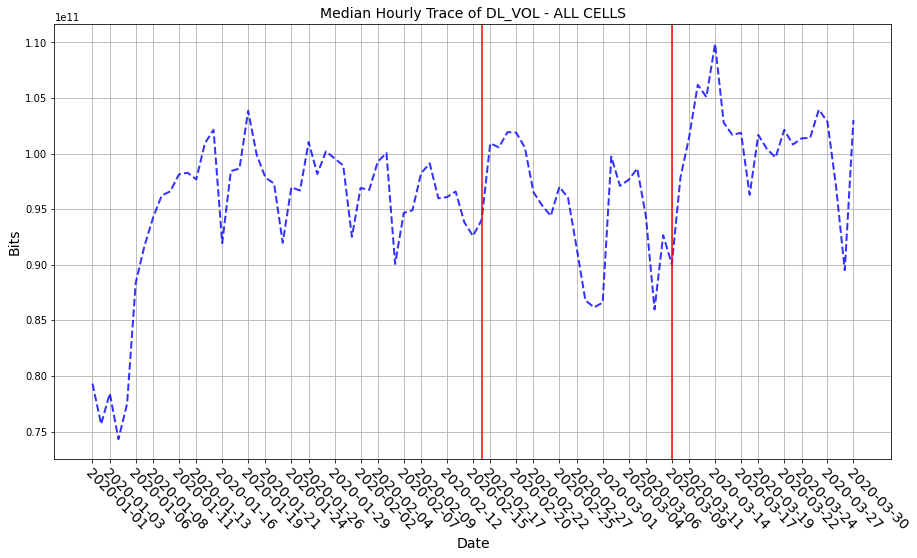

In [62]:
# This section plots the Traffic Downloaded from the ALL cells in a month

# Sort hourly samples by date
# .loc[cell_id,['Date',ref_KPI]] = Set new index to "cell_id" and select Columns by Name "Date" and "ref_KPI"
# ref = data.set_index('ECELL_ID').sort_values('Date').loc[cell_id,['Date',ref_KPI]]


# Create a copy of the original dataset
data_temp = data.copy()

# Set Daily granularity instead of Hourly granularity
data_temp['Date'] = pd.to_datetime(data_temp['Date']).dt.date

# Used to identify days with less measurments
# pd.set_option('display.max_rows', None)
# display(data_temp['Date'].value_counts())

# We drop the data about 31-03-2020 because we are computing daily stats and in this date we have only one measurment for the whole day
ref = data_temp.set_index('Date').sort_values('Date').drop(datetime.date(year=2020,month=3,day=31)).loc[:, [ref_KPI]]

# Sum all the "ref_KPI" values with same "Date"
ref = ref.groupby(level=0).sum()

# open new figure
fig, ax = plt.subplots(figsize=(15,8))

# plot data
ax.plot(list(range(0,len(ref))), ref[ref_KPI], linestyle='--', lw=2, color='b', alpha=.8) 

# Set plotting options
plt.xticks(color='black')
plt.yticks(color='black')
plt.grid(1)
ticks_label = ref.index
ticks = np.linspace(0, len(ref)-1, 35, dtype=int)
plt.xticks(ticks = ticks, labels = ticks_label[ticks], fontsize = 14)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor") 
plt.xlabel('Date', color='black', fontsize=14)
plt.ylabel('Bits', color='black', fontsize=14) # unit of measure depends on the considered KPI
plt.title('Median Hourly Trace of '+ref_KPI+' - ALL CELLS', fontsize=14)

# Draw a red line when there is a period change
plt.axvline(ticks_label.get_loc(datetime.date(year=2020,month=2,day=16)) ,color = 'r',label = 'Restrictions')
plt.axvline(ticks_label.get_loc(datetime.date(year=2020,month=3,day=9)) ,color = 'r',label = 'Full Lockdown')

plt.show()

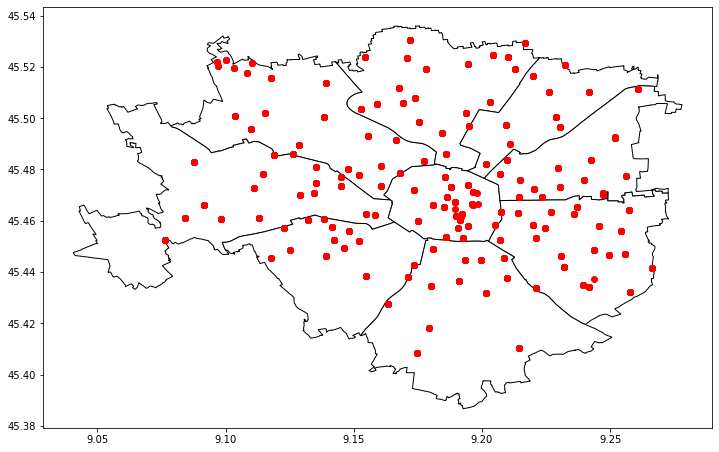

In [63]:
# Cell rappresentation with Geopandas
geo_data = geopandas.GeoDataFrame(locations, geometry=geopandas.points_from_xy(locations.LONG_X, locations.LAT_Y))

# Plot the map
milan = geopandas.read_file(file_path+'ds379_municipi_label.geojson')
ax = milan.plot(color='white', edgecolor='black', figsize=[12,15])


# Plot the cells
geo_data.plot(ax=ax, color='red')

plt.show()


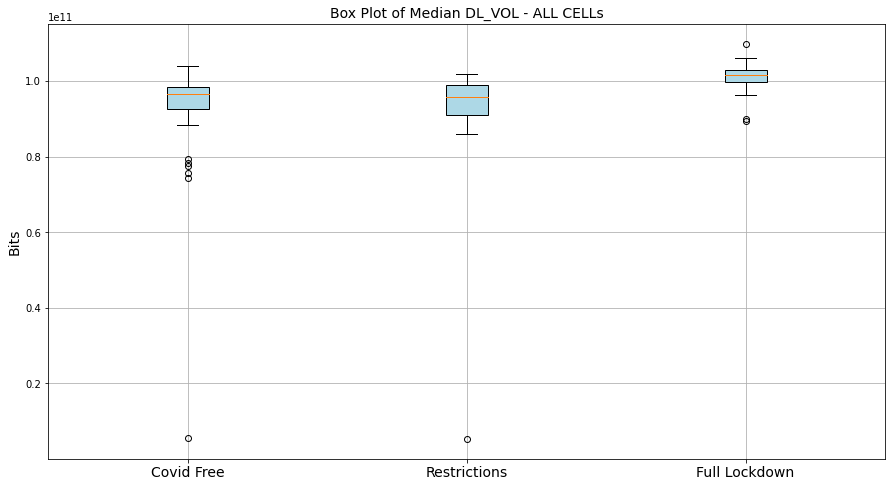


--------- Covid Free DL_VOL ---------
Median value: 96687510600.00
Average value: 92724161039.83
Standard deviation: 14558404652.36
--------- Restrictions DL_VOL ---------
Median value: 95672468856.00
Average value: 91322267457.00
Standard deviation: 18608666021.45
--------- Full Lockdown DL_VOL ---------
Median value: 101573474492.00
Average value: 100775650256.00
Standard deviation: 4504695443.99
>>>------ Covid Free DL_VOL Variation ------<<<
Median difference between Covid Free and Restrictions : -1.05%
Average difference between Covid Free and Restrictions : -1.51%
Std. deviation difference between Covid Free and Restrictions : 27.82%
Median difference between Covid Free and Full Lockdown : 5.05%
Average difference between Covid Free and Full Lockdown : 8.68%
Std. deviation difference between Covid Free and Full Lockdown : -69.06%
>>>------ Restrictions DL_VOL Variation ------<<<
Median difference between Restrictions and Full Lockdown : 6.17%
Average difference between Restricti

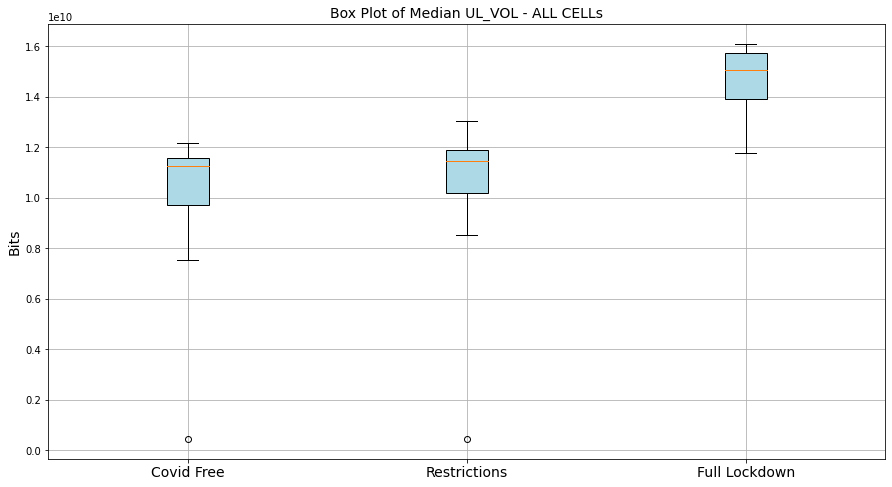


--------- Covid Free UL_VOL ---------
Median value: 11272327640.00
Average value: 10352520560.68
Standard deviation: 1919384604.12
--------- Restrictions UL_VOL ---------
Median value: 11480095564.00
Average value: 10590008270.33
Standard deviation: 2460465894.03
--------- Full Lockdown UL_VOL ---------
Median value: 15055708604.00
Average value: 14726507514.91
Standard deviation: 1214259769.59
>>>------ Covid Free UL_VOL Variation ------<<<
Median difference between Covid Free and Restrictions : 1.84%
Average difference between Covid Free and Restrictions : 2.29%
Std. deviation difference between Covid Free and Restrictions : 28.19%
Median difference between Covid Free and Full Lockdown : 33.56%
Average difference between Covid Free and Full Lockdown : 42.25%
Std. deviation difference between Covid Free and Full Lockdown : -36.74%
>>>------ Restrictions UL_VOL Variation ------<<<
Median difference between Restrictions and Full Lockdown : 31.15%
Average difference between Restrictions

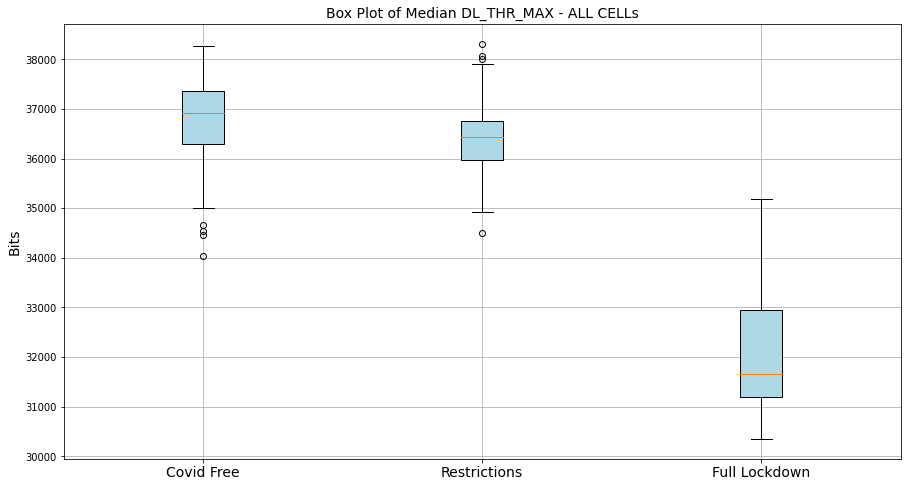


--------- Covid Free DL_THR_MAX ---------
Median value: 36921.34
Average value: 36688.49
Standard deviation: 962.73
--------- Restrictions DL_THR_MAX ---------
Median value: 36431.24
Average value: 36451.33
Standard deviation: 952.23
--------- Full Lockdown DL_THR_MAX ---------
Median value: 31657.86
Average value: 32185.83
Standard deviation: 1308.02
>>>------ Covid Free DL_THR_MAX Variation ------<<<
Median difference between Covid Free and Restrictions : -1.33%
Average difference between Covid Free and Restrictions : -0.65%
Std. deviation difference between Covid Free and Restrictions : -1.09%
Median difference between Covid Free and Full Lockdown : -14.26%
Average difference between Covid Free and Full Lockdown : -12.27%
Std. deviation difference between Covid Free and Full Lockdown : 35.87%
>>>------ Restrictions DL_THR_MAX Variation ------<<<
Median difference between Restrictions and Full Lockdown : -13.10%
Average difference between Restrictions and Full Lockdown : -11.70%
Std

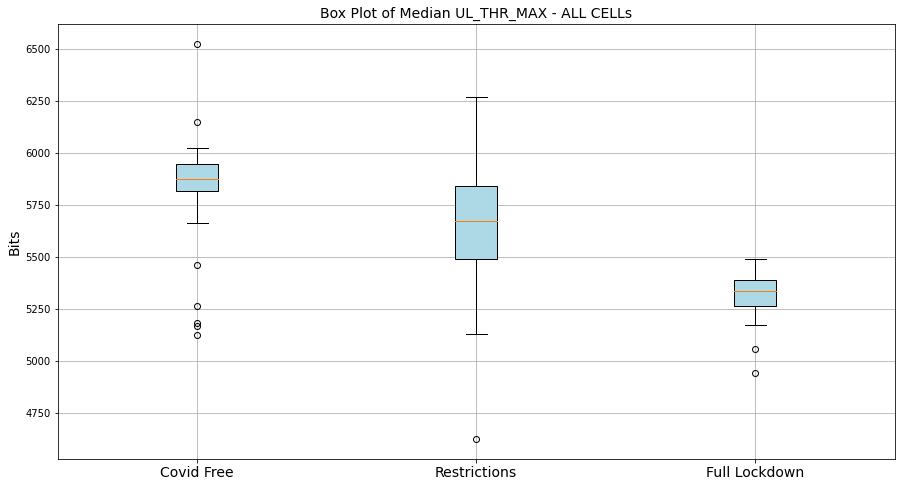


--------- Covid Free UL_THR_MAX ---------
Median value: 5875.97
Average value: 5832.88
Standard deviation: 242.88
--------- Restrictions UL_THR_MAX ---------
Median value: 5674.36
Average value: 5662.31
Standard deviation: 378.19
--------- Full Lockdown UL_THR_MAX ---------
Median value: 5333.43
Average value: 5303.49
Standard deviation: 128.26
>>>------ Covid Free UL_THR_MAX Variation ------<<<
Median difference between Covid Free and Restrictions : -3.43%
Average difference between Covid Free and Restrictions : -2.92%
Std. deviation difference between Covid Free and Restrictions : 55.71%
Median difference between Covid Free and Full Lockdown : -9.23%
Average difference between Covid Free and Full Lockdown : -9.08%
Std. deviation difference between Covid Free and Full Lockdown : -47.19%
>>>------ Restrictions UL_THR_MAX Variation ------<<<
Median difference between Restrictions and Full Lockdown : -6.01%
Average difference between Restrictions and Full Lockdown : -6.34%
Std. deviatio

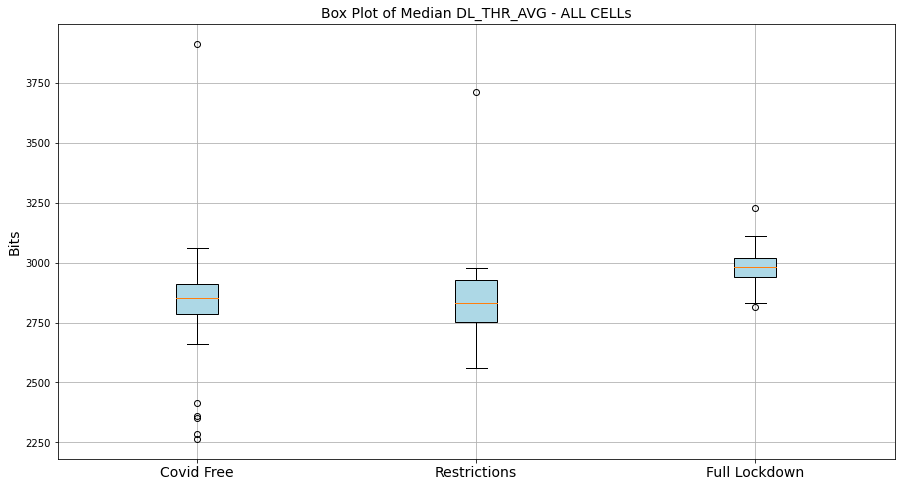


--------- Covid Free DL_THR_AVG ---------
Median value: 2851.08
Average value: 2822.99
Standard deviation: 239.82
--------- Restrictions DL_THR_AVG ---------
Median value: 2829.85
Average value: 2846.64
Standard deviation: 218.02
--------- Full Lockdown DL_THR_AVG ---------
Median value: 2979.95
Average value: 2982.10
Standard deviation: 90.86
>>>------ Covid Free DL_THR_AVG Variation ------<<<
Median difference between Covid Free and Restrictions : -0.74%
Average difference between Covid Free and Restrictions : 0.84%
Std. deviation difference between Covid Free and Restrictions : -9.09%
Median difference between Covid Free and Full Lockdown : 4.52%
Average difference between Covid Free and Full Lockdown : 5.64%
Std. deviation difference between Covid Free and Full Lockdown : -62.11%
>>>------ Restrictions DL_THR_AVG Variation ------<<<
Median difference between Restrictions and Full Lockdown : 5.30%
Average difference between Restrictions and Full Lockdown : 4.76%
Std. deviation diff

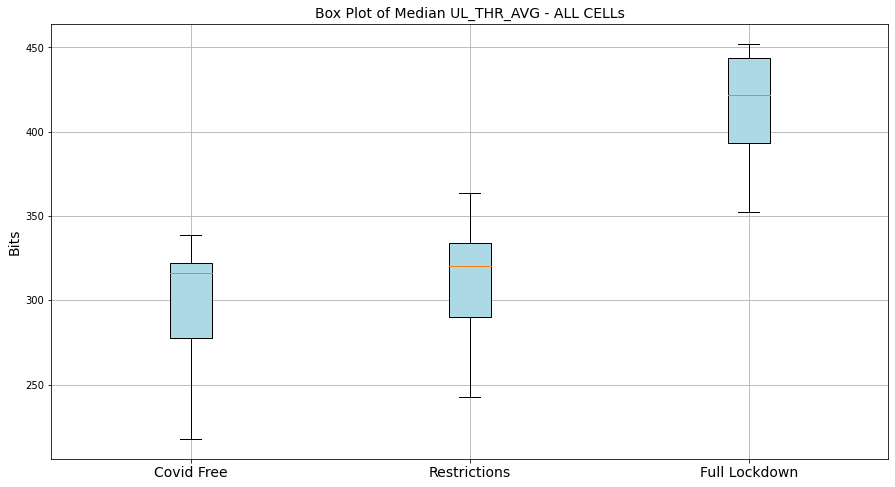


--------- Covid Free UL_THR_AVG ---------
Median value: 316.21
Average value: 298.66
Standard deviation: 32.52
--------- Restrictions UL_THR_AVG ---------
Median value: 320.31
Average value: 310.13
Standard deviation: 33.48
--------- Full Lockdown UL_THR_AVG ---------
Median value: 421.88
Average value: 416.74
Standard deviation: 29.52
>>>------ Covid Free UL_THR_AVG Variation ------<<<
Median difference between Covid Free and Restrictions : 1.30%
Average difference between Covid Free and Restrictions : 3.84%
Std. deviation difference between Covid Free and Restrictions : 2.96%
Median difference between Covid Free and Full Lockdown : 33.41%
Average difference between Covid Free and Full Lockdown : 39.54%
Std. deviation difference between Covid Free and Full Lockdown : -9.23%
>>>------ Restrictions UL_THR_AVG Variation ------<<<
Median difference between Restrictions and Full Lockdown : 31.71%
Average difference between Restrictions and Full Lockdown : 34.37%
Std. deviation difference 

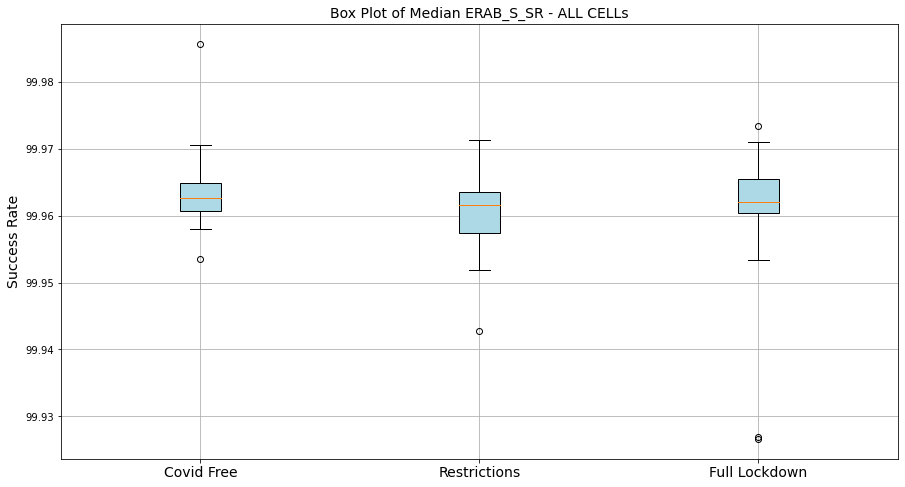


--------- Covid Free ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.00
--------- Restrictions ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.01
--------- Full Lockdown ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.01
>>>------ Covid Free ERAB_S_SR Variation ------<<<
Median difference between Covid Free and Restrictions : -0.00%
Average difference between Covid Free and Restrictions : -0.00%
Std. deviation difference between Covid Free and Restrictions : 29.56%
Median difference between Covid Free and Full Lockdown : -0.00%
Average difference between Covid Free and Full Lockdown : -0.00%
Std. deviation difference between Covid Free and Full Lockdown : 136.08%
>>>------ Restrictions ERAB_S_SR Variation ------<<<
Median difference between Restrictions and Full Lockdown : 0.00%
Average difference between Restrictions and Full Lockdown : -0.00%
Std. deviation difference between Res

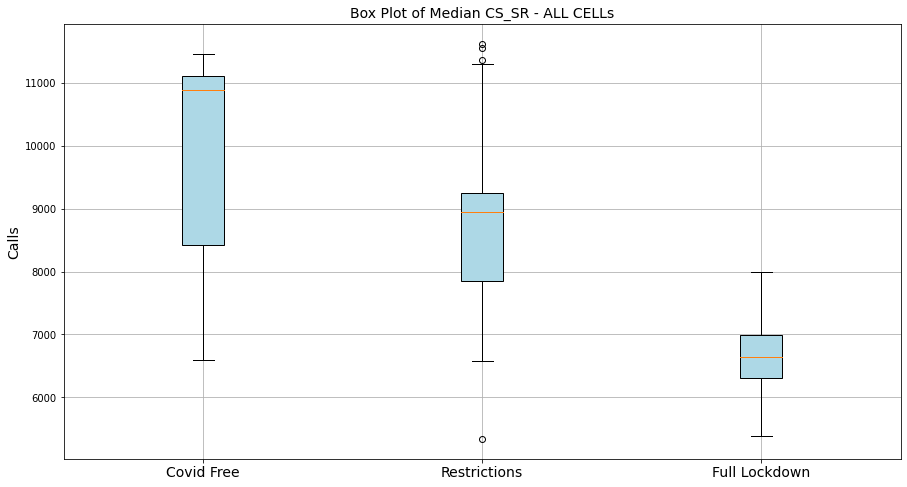


--------- Covid Free CS_SR ---------
Median value: 10881.89
Average value: 9870.74
Standard deviation: 1529.75
--------- Restrictions CS_SR ---------
Median value: 8950.49
Average value: 8801.19
Standard deviation: 1643.62
--------- Full Lockdown CS_SR ---------
Median value: 6640.26
Average value: 6731.95
Standard deviation: 633.76
>>>------ Covid Free CS_SR Variation ------<<<
Median difference between Covid Free and Restrictions : -17.75%
Average difference between Covid Free and Restrictions : -10.84%
Std. deviation difference between Covid Free and Restrictions : 7.44%
Median difference between Covid Free and Full Lockdown : -38.98%
Average difference between Covid Free and Full Lockdown : -31.80%
Std. deviation difference between Covid Free and Full Lockdown : -58.57%
>>>------ Restrictions CS_SR Variation ------<<<
Median difference between Restrictions and Full Lockdown : -25.81%
Average difference between Restrictions and Full Lockdown : -23.51%
Std. deviation difference betw

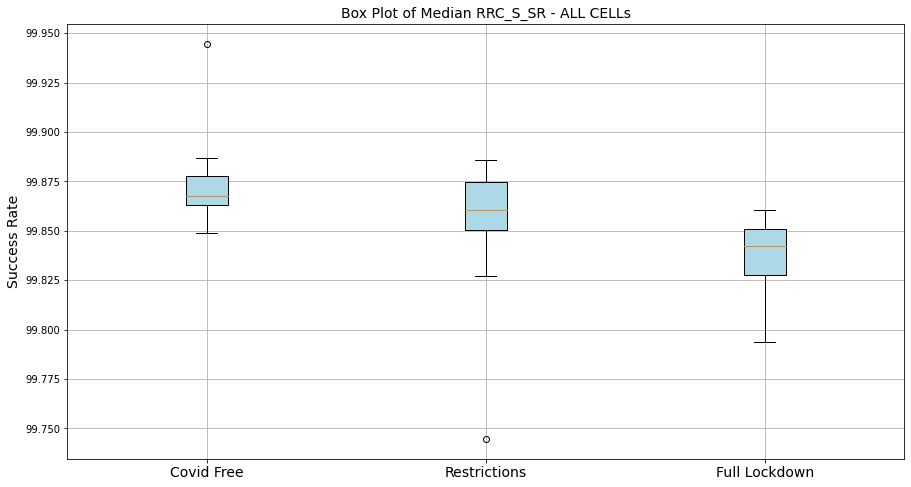


--------- Covid Free RRC_S_SR ---------
Median value: 99.87
Average value: 99.87
Standard deviation: 0.01
--------- Restrictions RRC_S_SR ---------
Median value: 99.86
Average value: 99.86
Standard deviation: 0.03
--------- Full Lockdown RRC_S_SR ---------
Median value: 99.84
Average value: 99.84
Standard deviation: 0.02
>>>------ Covid Free RRC_S_SR Variation ------<<<
Median difference between Covid Free and Restrictions : -0.01%
Average difference between Covid Free and Restrictions : -0.01%
Std. deviation difference between Covid Free and Restrictions : 99.34%
Median difference between Covid Free and Full Lockdown : -0.03%
Average difference between Covid Free and Full Lockdown : -0.03%
Std. deviation difference between Covid Free and Full Lockdown : 31.34%
>>>------ Restrictions RRC_S_SR Variation ------<<<
Median difference between Restrictions and Full Lockdown : -0.02%
Average difference between Restrictions and Full Lockdown : -0.02%
Std. deviation difference between Restrict

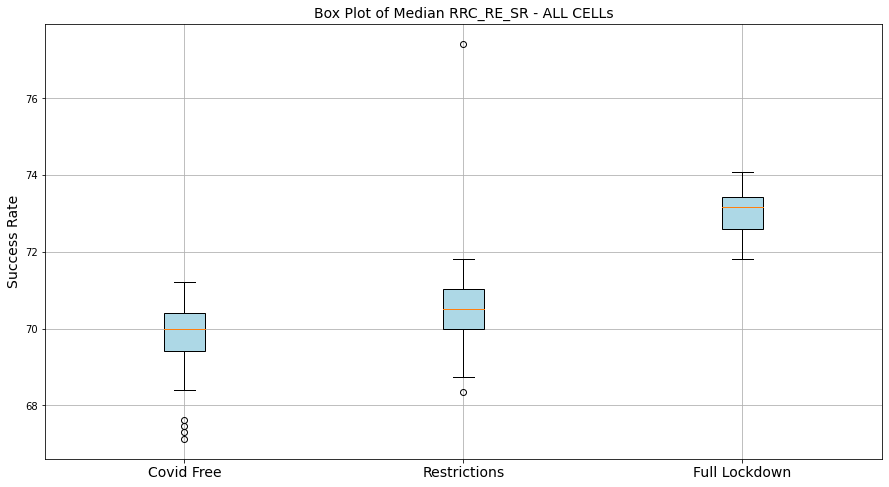


--------- Covid Free RRC_RE_SR ---------
Median value: 69.99
Average value: 69.77
Standard deviation: 0.95
--------- Restrictions RRC_RE_SR ---------
Median value: 70.50
Average value: 70.67
Standard deviation: 1.63
--------- Full Lockdown RRC_RE_SR ---------
Median value: 73.17
Average value: 73.05
Standard deviation: 0.60
>>>------ Covid Free RRC_RE_SR Variation ------<<<
Median difference between Covid Free and Restrictions : 0.73%
Average difference between Covid Free and Restrictions : 1.28%
Std. deviation difference between Covid Free and Restrictions : 71.04%
Median difference between Covid Free and Full Lockdown : 4.54%
Average difference between Covid Free and Full Lockdown : 4.70%
Std. deviation difference between Covid Free and Full Lockdown : -37.29%
>>>------ Restrictions RRC_RE_SR Variation ------<<<
Median difference between Restrictions and Full Lockdown : 3.79%
Average difference between Restrictions and Full Lockdown : 3.38%
Std. deviation difference between Restrict

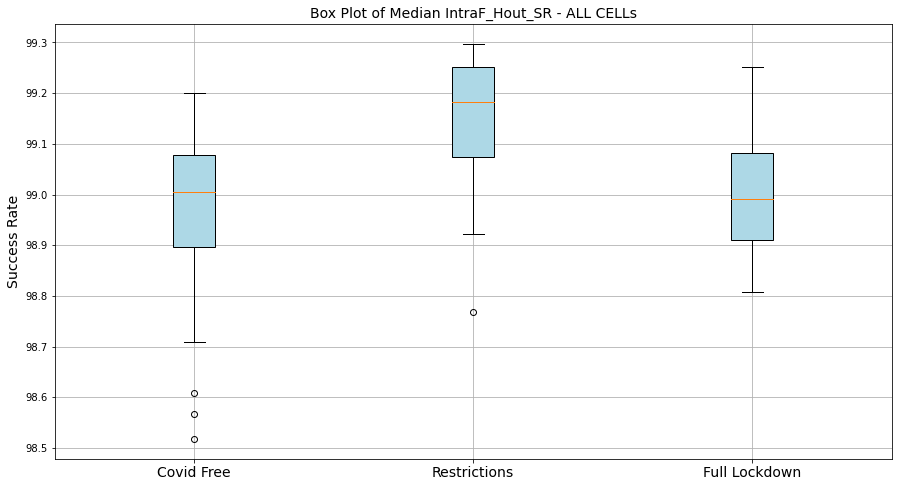


--------- Covid Free IntraF_Hout_SR ---------
Median value: 99.01
Average value: 98.97
Standard deviation: 0.16
--------- Restrictions IntraF_Hout_SR ---------
Median value: 99.18
Average value: 99.15
Standard deviation: 0.13
--------- Full Lockdown IntraF_Hout_SR ---------
Median value: 98.99
Average value: 99.00
Standard deviation: 0.12
>>>------ Covid Free IntraF_Hout_SR Variation ------<<<
Median difference between Covid Free and Restrictions : 0.18%
Average difference between Covid Free and Restrictions : 0.18%
Std. deviation difference between Covid Free and Restrictions : -20.25%
Median difference between Covid Free and Full Lockdown : -0.02%
Average difference between Covid Free and Full Lockdown : 0.03%
Std. deviation difference between Covid Free and Full Lockdown : -28.06%
>>>------ Restrictions IntraF_Hout_SR Variation ------<<<
Median difference between Restrictions and Full Lockdown : -0.19%
Average difference between Restrictions and Full Lockdown : -0.16%
Std. deviatio

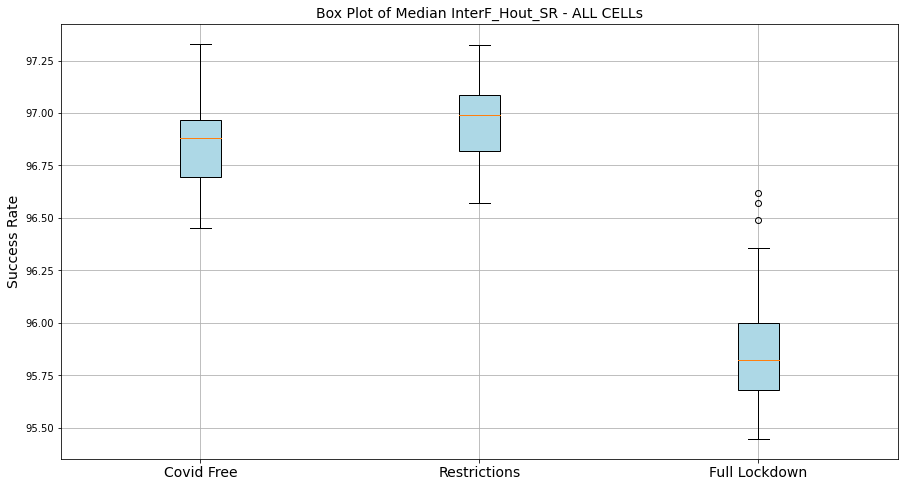


--------- Covid Free InterF_Hout_SR ---------
Median value: 96.88
Average value: 96.85
Standard deviation: 0.21
--------- Restrictions InterF_Hout_SR ---------
Median value: 96.99
Average value: 96.97
Standard deviation: 0.20
--------- Full Lockdown InterF_Hout_SR ---------
Median value: 95.82
Average value: 95.91
Standard deviation: 0.32
>>>------ Covid Free InterF_Hout_SR Variation ------<<<
Median difference between Covid Free and Restrictions : 0.11%
Average difference between Covid Free and Restrictions : 0.12%
Std. deviation difference between Covid Free and Restrictions : -4.99%
Median difference between Covid Free and Full Lockdown : -1.09%
Average difference between Covid Free and Full Lockdown : -0.97%
Std. deviation difference between Covid Free and Full Lockdown : 52.92%
>>>------ Restrictions InterF_Hout_SR Variation ------<<<
Median difference between Restrictions and Full Lockdown : -1.20%
Average difference between Restrictions and Full Lockdown : -1.09%
Std. deviation

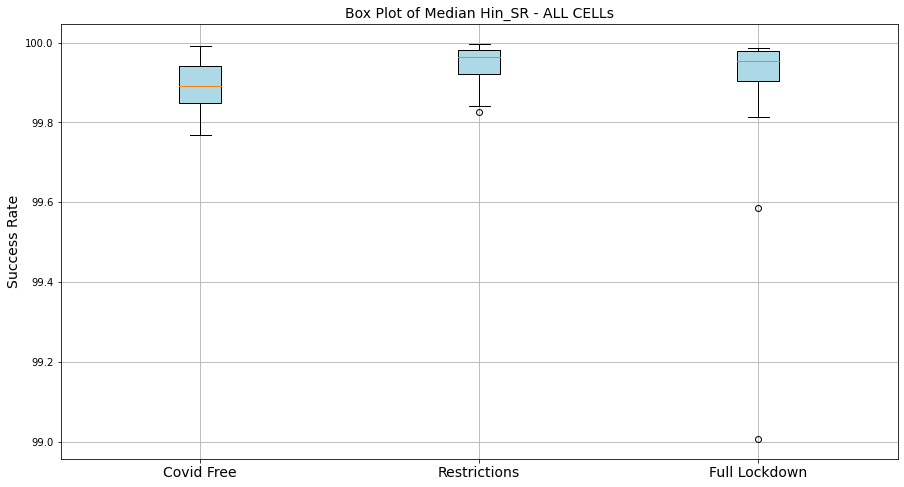


--------- Covid Free Hin_SR ---------
Median value: 99.89
Average value: 99.90
Standard deviation: 0.06
--------- Restrictions Hin_SR ---------
Median value: 99.96
Average value: 99.94
Standard deviation: 0.05
--------- Full Lockdown Hin_SR ---------
Median value: 99.95
Average value: 99.88
Standard deviation: 0.21
>>>------ Covid Free Hin_SR Variation ------<<<
Median difference between Covid Free and Restrictions : 0.07%
Average difference between Covid Free and Restrictions : 0.05%
Std. deviation difference between Covid Free and Restrictions : -13.86%
Median difference between Covid Free and Full Lockdown : 0.06%
Average difference between Covid Free and Full Lockdown : -0.01%
Std. deviation difference between Covid Free and Full Lockdown : 258.46%
>>>------ Restrictions Hin_SR Variation ------<<<
Median difference between Restrictions and Full Lockdown : -0.01%
Average difference between Restrictions and Full Lockdown : -0.06%
Std. deviation difference between Restrictions and Fu

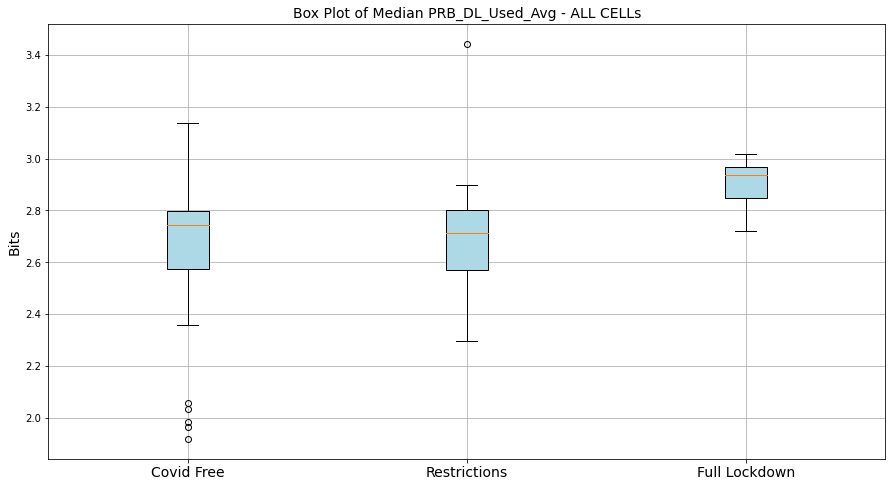


--------- Covid Free PRB_DL_Used_Avg ---------
Median value: 2.74
Average value: 2.64
Standard deviation: 0.26
--------- Restrictions PRB_DL_Used_Avg ---------
Median value: 2.71
Average value: 2.69
Standard deviation: 0.23
--------- Full Lockdown PRB_DL_Used_Avg ---------
Median value: 2.94
Average value: 2.90
Standard deviation: 0.09
>>>------ Covid Free PRB_DL_Used_Avg Variation ------<<<
Median difference between Covid Free and Restrictions : -1.02%
Average difference between Covid Free and Restrictions : 1.84%
Std. deviation difference between Covid Free and Restrictions : -11.47%
Median difference between Covid Free and Full Lockdown : 7.09%
Average difference between Covid Free and Full Lockdown : 9.77%
Std. deviation difference between Covid Free and Full Lockdown : -65.73%
>>>------ Restrictions PRB_DL_Used_Avg Variation ------<<<
Median difference between Restrictions and Full Lockdown : 8.20%
Average difference between Restrictions and Full Lockdown : 7.79%
Std. deviation d

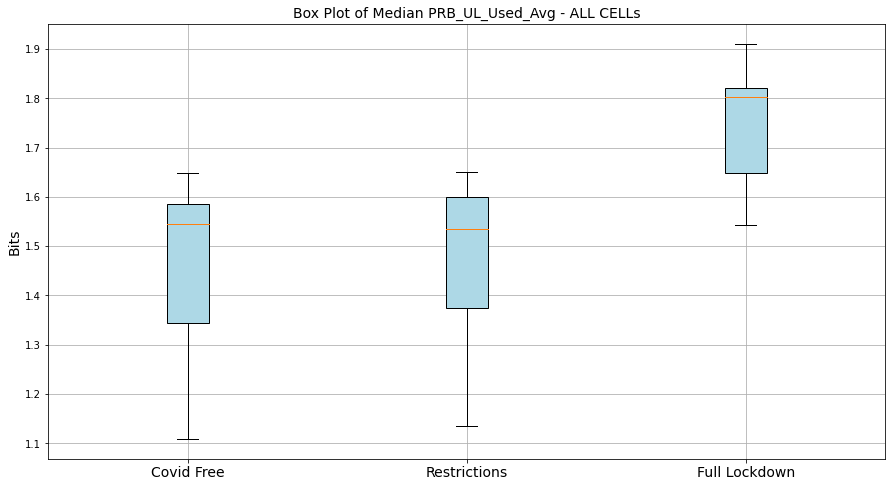


--------- Covid Free PRB_UL_Used_Avg ---------
Median value: 1.55
Average value: 1.46
Standard deviation: 0.16
--------- Restrictions PRB_UL_Used_Avg ---------
Median value: 1.53
Average value: 1.47
Standard deviation: 0.16
--------- Full Lockdown PRB_UL_Used_Avg ---------
Median value: 1.80
Average value: 1.75
Standard deviation: 0.11
>>>------ Covid Free PRB_UL_Used_Avg Variation ------<<<
Median difference between Covid Free and Restrictions : -0.71%
Average difference between Covid Free and Restrictions : 0.81%
Std. deviation difference between Covid Free and Restrictions : 2.24%
Median difference between Covid Free and Full Lockdown : 16.70%
Average difference between Covid Free and Full Lockdown : 19.93%
Std. deviation difference between Covid Free and Full Lockdown : -31.54%
>>>------ Restrictions PRB_UL_Used_Avg Variation ------<<<
Median difference between Restrictions and Full Lockdown : 17.54%
Average difference between Restrictions and Full Lockdown : 18.96%
Std. deviation

In [64]:
# This section makes a box plot of the daily statiscs regarding the number of connected 
# users to the cell taken as example. For each day, the following statistics are extracted from the considered
# KPI:
# - Median Value
# - 25th and 75th Quantiles
# - Max and Min values

# For reference about how to read a box plot go here: 
# https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51

# If operation == 0 do the sum of the ref_KPI of the day
# If operation == 1 do the average of the ref_KPI of the day
def periods_box_plot_daily(ref_KPI, operation, ylabel):

  # Create a copy of the original dataset
  covid_free_temp = covid_free.copy()
  # Set Daily granularity instead of Hourly granularity
  covid_free_temp['Date'] = pd.to_datetime(covid_free_temp['Date']).dt.date
  # Set new dataset index to "Date" and keep only the "ref_KPI" column
  covid_free_one_KPI = covid_free_temp.set_index('Date').sort_values('Date').loc[:, [ref_KPI]]
  
  restrictions_temp = restrictions.copy()
  restrictions_temp['Date'] = pd.to_datetime(restrictions_temp['Date']).dt.date
  restrictions_one_KPI = restrictions_temp.set_index('Date').sort_values('Date').loc[:, [ref_KPI]]
  
  full_lockdown_temp = full_lockdown.copy()
  full_lockdown_temp['Date'] = pd.to_datetime(full_lockdown_temp['Date']).dt.date
  # We drop the data about 31-03-2020 because we are comuting daily stats and in this date we have only one measurment for the whole day
  full_lockdown_one_KPI = full_lockdown_temp.set_index('Date').sort_values('Date').loc[:, [ref_KPI]].drop(datetime.date(year=2020,month=3,day=31))
  

  if operation == 0:
    # Sum all the "ref_KPI" values with same "Date"
    covid_free_one_KPI = covid_free_one_KPI.groupby(level=0).sum()
    restrictions_one_KPI = restrictions_one_KPI.groupby(level=0).sum()
    full_lockdown_one_KPI = full_lockdown_one_KPI.groupby(level=0).sum()
  else:
    # Make the mean of all the "ref_KPI" values with same "Date"
    covid_free_one_KPI = covid_free_one_KPI.groupby(level=0).mean()
    restrictions_one_KPI = restrictions_one_KPI.groupby(level=0).mean()
    full_lockdown_one_KPI = full_lockdown_one_KPI.groupby(level=0).mean()

  # open new figure
  fig, ax = plt.subplots(figsize=(15,8))
  
  # covid_free_one_KPI have only one KPI but we need "[ref_KPI]" to use the "tolist()" function
  periods_data_list = [covid_free_one_KPI[ref_KPI].tolist(), restrictions_one_KPI[ref_KPI].tolist(), full_lockdown_one_KPI[ref_KPI].tolist()]

  bplots = []
  for i in range(3):
    bplots.append(ax.boxplot(periods_data_list[i], positions = [i], patch_artist=True))

  for bplot in bplots:
    for patch in bplot['boxes']:
      patch.set_facecolor('lightblue')

  # Set plotting options
  plt.xticks(color='black')
  plt.yticks(color='black')
  plt.grid(1)
  plt.xticks(ticks = list(range(3)), labels = ['Covid Free','Restrictions','Full Lockdown'], fontsize = 14)
  plt.setp( ax.xaxis.get_majorticklabels(), ha="center") 
  plt.ylabel(ylabel, color='black', fontsize=14)
  plt.title('Box Plot of Median '+ref_KPI+' - ALL CELLs', fontsize=14)
  plt.show()

  print()
  
  median_values = []
  average_values = []
  sd_valuea = []

  # Print statistical informations:
  for i in range(3):
    print('---------', periods_lables[i], ref_KPI,'---------')
    median_values.append(np.median(periods_data_list[i]))
    print('Median value:', "{0:.2f}".format(median_values[i]))
    average_values.append(np.mean(periods_data_list[i]))
    print('Average value:', "{0:.2f}".format( average_values[i]))
    sd_valuea.append(np.std(periods_data_list[i]))
    print('Standard deviation:', "{0:.2f}".format(sd_valuea[i]))

  # Statistical comparison between the first period and the second period
  print('>>>------', periods_lables[0], ref_KPI, 'Variation ------<<<')
  print("Median difference between", periods_lables[0] ,"and",periods_lables[1] ,": {0:.2f}%".format(((median_values[1] - median_values[0]) / abs(median_values[0])) * 100))
  print("Average difference between", periods_lables[0] ,"and",periods_lables[1] ,": {0:.2f}%".format(((average_values[1] - average_values[0]) / abs(average_values[0])) * 100))
  print("Std. deviation difference between", periods_lables[0] ,"and",periods_lables[1] ,": {0:.2f}%".format(((sd_valuea[1] - sd_valuea[0]) / abs(sd_valuea[0])) * 100))

   # Statistical comparison between the first period and the third period
  print("Median difference between", periods_lables[0] ,"and",periods_lables[2] ,": {0:.2f}%".format(((median_values[2] - median_values[0]) / abs(median_values[0])) * 100))
  print("Average difference between", periods_lables[0] ,"and",periods_lables[2] ,": {0:.2f}%".format(((average_values[2] - average_values[0]) / abs(average_values[0])) * 100))
  print("Std. deviation difference between", periods_lables[0] ,"and",periods_lables[2] ,": {0:.2f}%".format(((sd_valuea[2] - sd_valuea[0]) / abs(sd_valuea[0])) * 100))

  # Statistical comparison between the second period and the third period
  print('>>>------', periods_lables[1], ref_KPI, 'Variation ------<<<')
  print("Median difference between", periods_lables[1] ,"and",periods_lables[2] ,": {0:.2f}%".format(((median_values[2] - median_values[1]) / abs(median_values[1])) * 100))
  print("Average difference between", periods_lables[1] ,"and",periods_lables[2] ,": {0:.2f}%".format(((average_values[2] - average_values[1]) / abs(average_values[1])) * 100))
  print("Std. deviation difference between", periods_lables[1] ,"and",periods_lables[2] ,": {0:.2f}%".format(((sd_valuea[2] - sd_valuea[1]) / abs(sd_valuea[1])) * 100))

periods_box_plot_daily('DL_VOL', 0, 'Bits')
print()
periods_box_plot_daily('UL_VOL', 0, 'Bits')
print()
periods_box_plot_daily('DL_THR_MAX', 1, 'Bits')
print()
periods_box_plot_daily('UL_THR_MAX', 1, 'Bits')
print()
periods_box_plot_daily('DL_THR_AVG', 1, 'Bits')
print()
periods_box_plot_daily('UL_THR_AVG', 1, 'Bits')
print()
periods_box_plot_daily('ERAB_S_SR', 1, 'Success Rate')
print()
periods_box_plot_daily('CS_SR', 1, 'Calls')
print()
periods_box_plot_daily('RRC_S_SR', 1, 'Success Rate')
print()
periods_box_plot_daily('RRC_RE_SR', 1, 'Success Rate')
print()
periods_box_plot_daily('IntraF_Hout_SR', 1, 'Success Rate')
print()
periods_box_plot_daily('InterF_Hout_SR', 1, 'Success Rate')
print()
periods_box_plot_daily('Hin_SR', 1, 'Success Rate')
print()
periods_box_plot_daily('PRB_DL_Used_Avg', 1, 'Bits')
print()
periods_box_plot_daily('PRB_UL_Used_Avg', 1, 'Bits')
print()
